In [1]:
import os
import pandas as pd

In [2]:
cwd=os.getcwd()

In [3]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [4]:
us = pd.read_csv(cwd+"/covid-19-data/us.csv")
counties_df = pd.read_csv(cwd+"/covid-19-data/us-counties.csv")
states_df = pd.read_csv(cwd+"/covid-19-data/us-states.csv")
counties20 = pd.read_csv(cwd+"/covid-19-data/us-counties-2020.csv")
counties21 = pd.read_csv(cwd+"/covid-19-data/us-counties-2021.csv")
counties22 = pd.read_csv(cwd+"/covid-19-data/us-counties-2022.csv")
facilities = pd.read_csv(cwd+"/covid-19-data/prisons/facilities.csv")
systems = pd.read_csv(cwd+"/covid-19-data/prisons/systems.csv")
colleges =  pd.read_csv(cwd+"/covid-19-data/colleges/colleges.csv")
c20_avg = pd.read_csv(cwd+"/covid-19-data/rolling-averages/us-counties-2020.csv")
c21_avg = pd.read_csv(cwd+"/covid-19-data/rolling-averages/us-counties-2021.csv")
c22_avg = pd.read_csv(cwd+"/covid-19-data/rolling-averages/us-counties-2022.csv")

In [5]:
us.head()

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0


In [6]:
c20_avg.head()

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,2020-01-21,USA-53061,Snohomish,Washington,1,0.14,0.02,0,0.0,0.0
1,2020-01-22,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
2,2020-01-23,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
3,2020-01-24,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
4,2020-01-24,USA-17031,Cook,Illinois,1,0.14,0.00,0,0.0,0.0


In [7]:
states_df.isna().sum()

date      0
state     0
fips      0
cases     0
deaths    0
dtype: int64

In [8]:
states_df.shape

(44750, 5)

those are the dimentions of states dataframe
it is clean

In [9]:
colleges.head()

,date,state,county,city,ipeds_id,college,cases,cases_2021,notes
0,2021-05-26,Alabama,Madison,Huntsville,100654,Alabama A&M University,41,NaN,NaN
1,2021-05-26,Alabama,Montgomery,Montgomery,100724,Alabama State University,2,NaN,NaN
2,2021-05-26,Alabama,Limestone,Athens,100812,Athens State University,45,10.0,NaN
3,2021-05-26,Alabama,Lee,Auburn,100858,Auburn University,2742,567.0,NaN
4,2021-05-26,Alabama,Montgomery,Montgomery,100830,Auburn University at Montgomery,220,80.0,NaN


In [10]:
colleges.shape

(1948, 9)

In [11]:
colleges['date'].unique()


array(['2021-05-26'], dtype=object)

we are going to attempt clustering of the states based on deaths and cases. First we have to deal with missing data

In [12]:
states_df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [13]:
Nstates_df.sort_values(['state','date'])

,date,state,fips,cases,deaths
586,2020-03-13,Alabama,1,6,0
637,2020-03-14,Alabama,1,12,0
689,2020-03-15,Alabama,1,23,0
742,2020-03-16,Alabama,1,29,0
795,2020-03-17,Alabama,1,39,0
...,...,...,...,...,...
44525,2022-05-16,Wyoming,56,157031,1817
44581,2022-05-17,Wyoming,56,157409,1820
44637,2022-05-18,Wyoming,56,157409,1820
44693,2022-05-19,Wyoming,56,157409,1820


counties21_clean = counties21.dropna(axis=0)
c21_counties = pd.DataFrame(counties21_clean.groupby(["state", "county"])[["cases", "deaths"]].max())
c21_counties = c21_counties.astype({"deaths": int})
c21_counties.head()

In [15]:
c21_counties = c21_counties.reset_index(level=0)
c21_counties.head()

,state,cases,deaths
county,,,
Autauga,Alabama,11018,160
Baldwin,Alabama,39911,593
Barbour,Alabama,3860,81
Bibb,Alabama,4533,95
Blount,Alabama,11256,198


In [16]:
c21_counties.shape

(3140, 3)

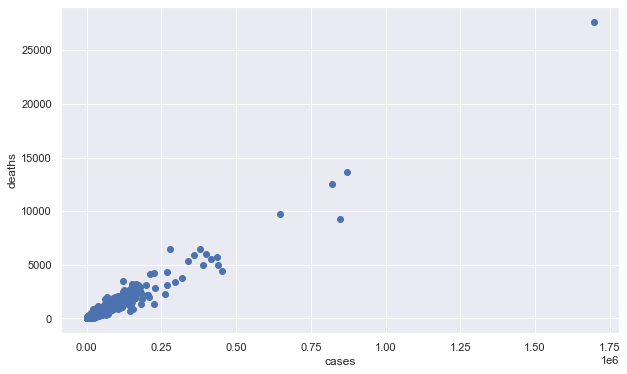

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(c21_counties['cases'],c21_counties['deaths'])
ax.set_xlabel('cases')
ax.set_ylabel('deaths');

In [18]:
c21_states = pd.DataFrame(counties21_clean.groupby(["state"])[["cases", "deaths"]].max())
c21_states = c21_states.astype({"deaths": int})
c21_states.head()


,cases,deaths
state,,
Alabama,126583,2024
Alaska,63352,419
Arizona,870996,13675
Arkansas,65856,966
California,1697286,27637


In [19]:
c21_states = c21_states.reset_index(level=0)
c21_states.head()

,state,cases,deaths
0,Alabama,126583,2024
1,Alaska,63352,419
2,Arizona,870996,13675
3,Arkansas,65856,966
4,California,1697286,27637


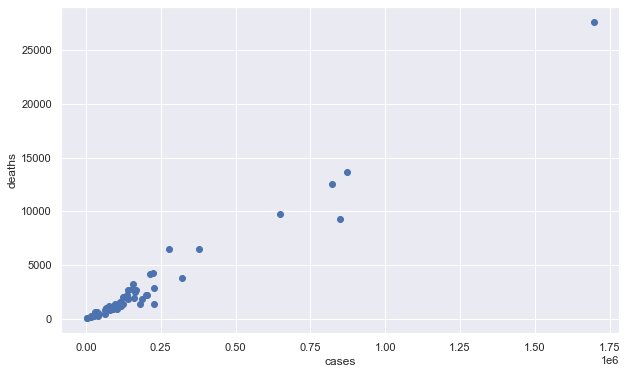

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(c21_states['cases'],c21_states['deaths'])
ax.set_xlabel('cases')
ax.set_ylabel('deaths');

In [21]:
Deaths = c21_states.values[:,-1].reshape(-1,1)
Cases = c21_states.values[:,-2].reshape(-1,1)

In [22]:
type(Deaths)

numpy.ndarray

In [23]:
# Initialize the Linear model. The fit_intercept paramenter tell the model not to fit the intercept
ols = linear_model.LinearRegression( fit_intercept=False)
# Fit the model to the data
ols.fit(Cases,Deaths)

LinearRegression(fit_intercept=False)

In [24]:
# Extract the R_Squared score
print("R^2 score: ", ols.score(Cases,Deaths))

R^2 score:  0.963777201490859


ols.coef_

In [25]:
ols.coef_

array([[0.01513011]])

with one utin increase on cases it is expected to have increase of deaths on 1.5%

In [26]:
deaths_pred=ols.predict(Cases)

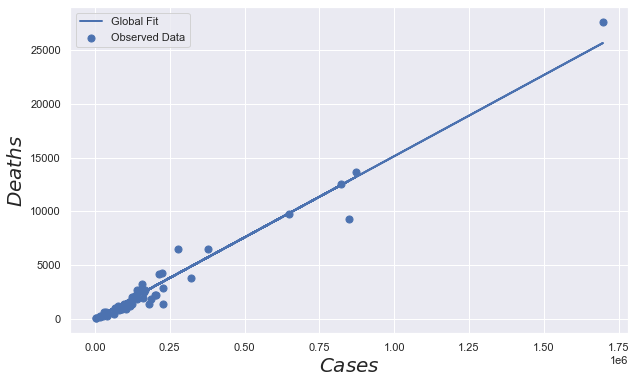

In [27]:
#plotthe results
fig = plt.figure(figsize=[10,6])
plt.scatter(Cases,Deaths,label='Observed Data',s=50)

plt.plot(Cases,deaths_pred, label='Global Fit',linewidth=2)
plt.xlabel('$Cases$',fontsize=20)
plt.ylabel('$Deaths$',fontsize=20)
plt.legend();

we should remove the outliers that affect the fit


use split training and validation and then standardize them


In [33]:
Deaths2 = c21_counties.values[:,-1].reshape(-1,1)
Cases2 = c21_counties.values[:,-2].reshape(-1,1)

In [37]:
#make it a dataframe
cases_deaths=c21_counties[['cases','deaths']] 
type(cases_deaths)

pandas.core.frame.DataFrame

In [40]:
#standardize

from sklearn.model_selection import train_test_split
train, test = train_test_split(cases_deaths, test_size = 0.3)


In [43]:
from sklearn.preprocessing import StandardScaler
scaler_sd = StandardScaler()
# Get scaling parameters with the train sample exclusively, using the Scaler.fit() function
scaler_sd.fit(train)


StandardScaler()

In [45]:
# Scale data using Scaler.transform()
df_train_scaled_sd = pd.DataFrame(scaler_sd.transform(train))
df_test_scaled_sd = pd.DataFrame(scaler_sd.transform(test))

In [47]:
df_train_scaled_sd.describe()

,0,1
count,2.198000e+03,2.198000e+03
mean,2.427034e-17,4.419678e-18
std,1.000228e+00,1.000228e+00
min,-2.827451e-01,-2.774045e-01
25%,-2.499798e-01,-2.376046e-01
50%,-2.035153e-01,-1.875704e-01
75%,-7.827007e-02,-6.049483e-02
max,2.931787e+01,3.114977e+01


In [48]:
df_test_scaled_sd.describe()

,0,1
count,942.000000,942.000000
mean,0.030715,0.019959
std,0.817692,0.727205
min,-0.281943,-0.277405
25%,-0.250089,-0.242153
50%,-0.205233,-0.185296
75%,-0.075807,-0.062769
max,7.584099,6.603438


In [52]:
# Create linear regression object
regr = linear_model.LinearRegression()

X_train=df_train_scaled_sd.values[:,0].reshape(-1,1)
y_train=df_train_scaled_sd.values[:,1].reshape(-1,1)
X_test=df_test_scaled_sd.values[:,0].reshape(-1,1)
y_test=df_test_scaled_sd.values[:,1].reshape(-1,1)
# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [54]:
# The intercept
print('Interccept: \n', regr.intercept_)
# The coefficients
print('Coefficients: \n', regr.coef_)

Interccept: 
 [4.13099044e-18]
Coefficients: 
 [[0.98141019]]


In [58]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#results on test set
print('MSE: %.2f' % mean_squared_error(y_test, y_pred))
print('R^2: %.2f' % r2_score(y_test, y_pred)) 

MSE: 0.05
R^2: 0.91


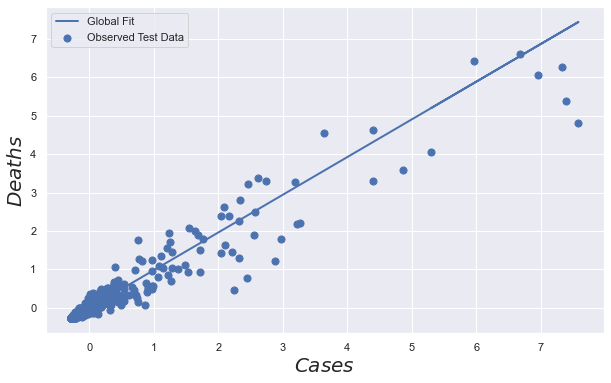

In [61]:
#plotthe results
fig = plt.figure(figsize=[10,6])
plt.scatter(X_test,y_test,label='Observed Test Data',s=50)

plt.plot(X_test,y_pred, label='Global Fit',linewidth=2)
plt.xlabel('$Cases$',fontsize=20)
plt.ylabel('$Deaths$',fontsize=20)
plt.legend();

### CLUSTERING:

In [62]:
# import the KMeans clustering model from scikit-learn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
A = df_train_scaled_sd.values

In [67]:
# Initialise the model for two clusters, "n_init" defines the number of time the k-means 
# algorithm will be run with different centroid seeds. and "init" defines the initialization for the clusters
# we will use random
k_means = KMeans(n_clusters=2, n_init=10, init='random')
# Train the model on the data
k_means.fit(A)
# save the calues for the labels (list of clusters to which each element of the data belongs) 
# and the centers of the clusters
labels = k_means.labels_
centers = k_means.cluster_centers_

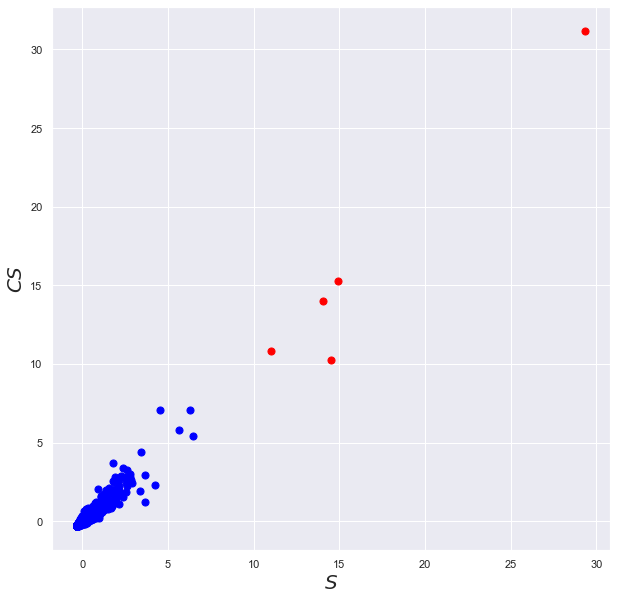

In [68]:
fig = plt.figure(figsize=[10,10])
# get the elemnets that belong to cluster 0
idx_0 = labels ==0
# Plot the cluster 0 elements in red
plt.scatter(A[idx_0,0],A[idx_0,1],s=50,color='red')
# get elements that belong to cluster 1
idx_0 = labels ==1
# Plot the elemntes of cluster 1 in blue
plt.scatter(A[idx_0,0],A[idx_0,1],s=50,color='blue')
plt.xlabel('$S$',fontsize=20)
plt.ylabel('$CS$',fontsize=20);

The method is influenced by the outliers keep only those who are close together


In [70]:
df_train_scaled_sd.head()

,0,1
0,-0.084296,-0.162553
1,-0.237872,-0.222822
2,0.207039,0.195646
3,-0.154317,-0.082953
4,-0.223205,-0.228507


In [75]:
df_train_scaled_sd.columns = ['cases_std', 'deaths_std']

In [76]:
df_train_scaled_sd.head()

,cases_std,deaths_std
0,-0.084296,-0.162553
1,-0.237872,-0.222822
2,0.207039,0.195646
3,-0.154317,-0.082953
4,-0.223205,-0.228507


In [77]:
df_train_scaled_sd_new=df_train_scaled_sd[df_train_scaled_sd.cases_std<4]

In [80]:
df_train_scaled_sd_new.shape


(2188, 2)

In [81]:
df_train_scaled_sd.shape

(2198, 2)

In [83]:
A2 = df_train_scaled_sd_new.values

In [85]:
# Initialise the model for two clusters, "n_init" defines the number of time the k-means 
# algorithm will be run with different centroid seeds. and "init" defines the initialization for the clusters
# we will use random
k_means = KMeans(n_clusters=2, n_init=10, init='random')
# Train the model on the data
k_means.fit(A2)
# save the calues for the labels (list of clusters to which each element of the data belongs) 
# and the centers of the clusters
labels = k_means.labels_
centers = k_means.cluster_centers_

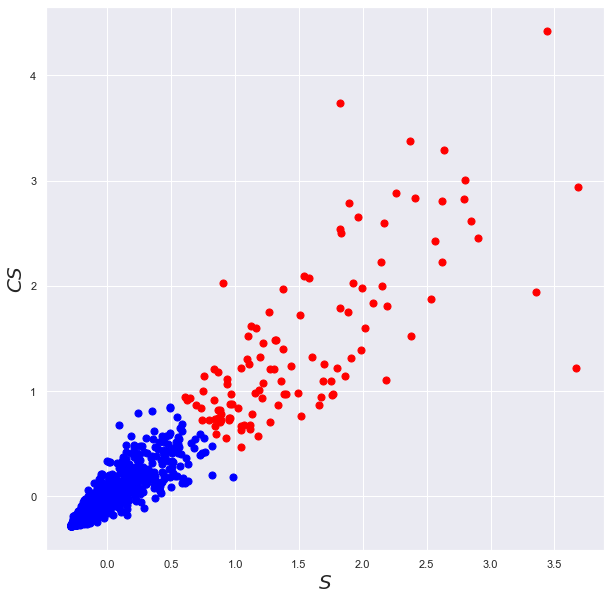

In [89]:
fig = plt.figure(figsize=[10,10])
# get the elemnets that belong to cluster 0
idx_0 = labels ==0
# Plot the cluster 0 elements in red
plt.scatter(A2[idx_0,0],A2[idx_0,1],s=50,color='red')
# get elements that belong to cluster 1
idx_0 = labels ==1
# Plot the elemntes of cluster 1 in blue
plt.scatter(A2[idx_0,0],A2[idx_0,1],s=50,color='blue')
plt.xlabel('$S$',fontsize=20)
plt.ylabel('$CS$',fontsize=20);

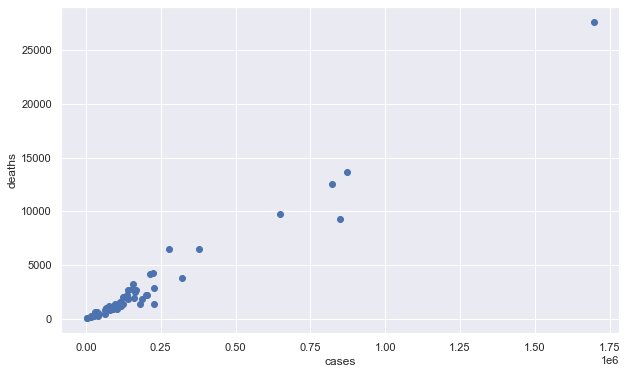

In [90]:
#lets do it only for states
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(c21_states['cases'],c21_states['deaths'])
ax.set_xlabel('cases')
ax.set_ylabel('deaths');

In [92]:
c21_states.shape

(53, 3)

In [94]:
#standardize them to see if the outliers leave
#make it a dataframe
cases_deaths=c21_states[['cases','deaths']]

In [95]:
cases_deaths.head()

,cases,deaths
0,126583,2024
1,63352,419
2,870996,13675
3,65856,966
4,1697286,27637


In [100]:
scaler_sd = StandardScaler()
# Get scaling parameters with the train sample exclusively, using the Scaler.fit() function
scaler_sd.fit(cases_deaths)

StandardScaler()

In [101]:
cases_deaths.head()

,cases,deaths
0,126583,2024
1,63352,419
2,870996,13675
3,65856,966
4,1697286,27637


In [102]:
# Scale data using Scaler.transform()
df_cases_deaths_sd = pd.DataFrame(scaler_sd.transform(cases_deaths))

In [103]:
df_cases_deaths_sd.head()

,0,1
0,-0.273352,-0.200247
1,-0.495539,-0.556681
2,2.342434,2.387175
3,-0.486740,-0.435204
4,5.245927,5.487817


In [105]:
df_cases_deaths_sd.columns = ['state_cases_std', 'state_deaths_std']

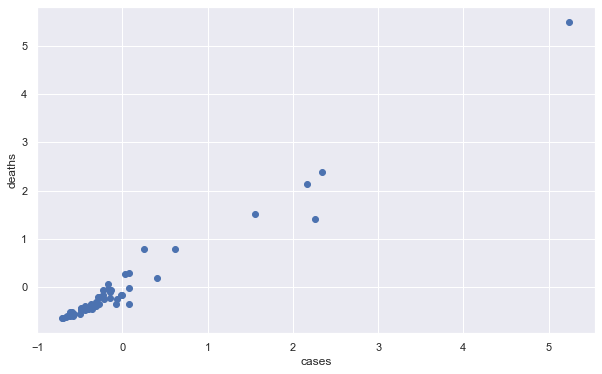

In [106]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df_cases_deaths_sd['state_cases_std'],df_cases_deaths_sd['state_deaths_std'])
ax.set_xlabel('cases')
ax.set_ylabel('deaths');

In [107]:
#remove outliers
df_cases_deaths_sd_new=df_cases_deaths_sd[df_cases_deaths_sd.state_cases_std<1]

In [108]:
A2 = df_cases_deaths_sd_new.values

In [109]:
# Initialise the model for two clusters, "n_init" defines the number of time the k-means 
# algorithm will be run with different centroid seeds. and "init" defines the initialization for the clusters
# we will use random
k_means = KMeans(n_clusters=2, n_init=10, init='random')
# Train the model on the data
k_means.fit(A2)
# save the calues for the labels (list of clusters to which each element of the data belongs) 
# and the centers of the clusters
labels = k_means.labels_
centers = k_means.cluster_centers_

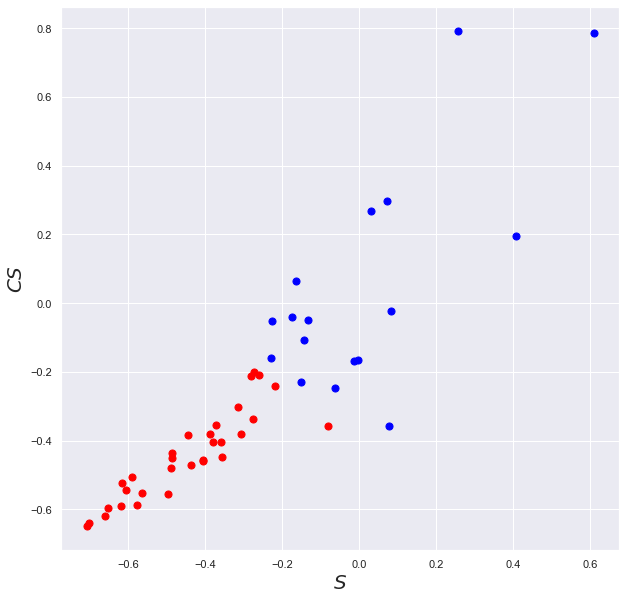

In [110]:
fig = plt.figure(figsize=[10,10])
# get the elemnets that belong to cluster 0
idx_0 = labels ==0
# Plot the cluster 0 elements in red
plt.scatter(A2[idx_0,0],A2[idx_0,1],s=50,color='red')
# get elements that belong to cluster 1
idx_0 = labels ==1
# Plot the elemntes of cluster 1 in blue
plt.scatter(A2[idx_0,0],A2[idx_0,1],s=50,color='blue')
plt.xlabel('$S$',fontsize=20)
plt.ylabel('$CS$',fontsize=20);

using 3 clusters

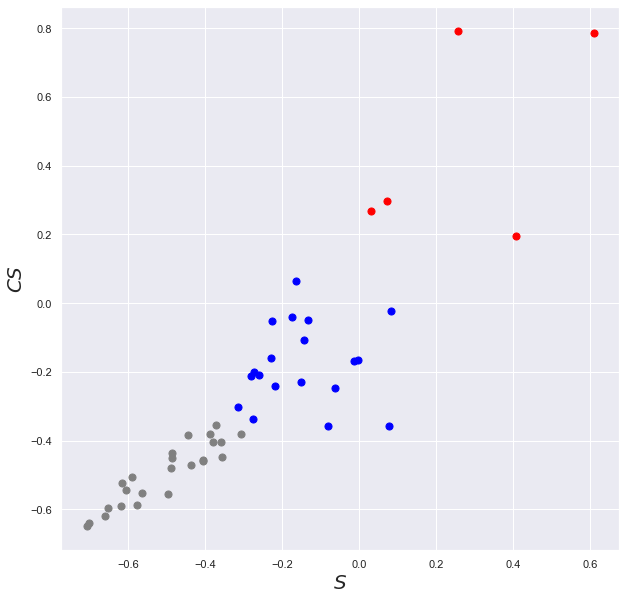

In [113]:
# Initialize the model but this time w will ask for 3 clusters
k_means = KMeans(n_clusters=3, n_init=10,init='random')
k_means.fit(A2)
# get labels and scores
labels = k_means.labels_
centers = k_means.cluster_centers_
fig = plt.figure(figsize=[10,10])
# Pot elements in cluster 0, 1 and 2
idx_0 = labels ==0
plt.scatter(A2[idx_0,0],A2[idx_0,1],s=50,color='red')
idx_0 = labels ==1
plt.scatter(A2[idx_0,0],A2[idx_0,1],s=50,color='blue')
idx_2 = labels ==2
plt.scatter(A2[idx_2,0],A2[idx_2,1],s=50,color='gray')
plt.xlabel('$S$',fontsize=20)
plt.ylabel('$CS$',fontsize=20);
